In [20]:
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, rescale_intensity
from scipy import signal
from sklearn.metrics import mean_squared_error
import numpy as np
import skimage.io as io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv
from skimage.util import random_noise as rn
import scipy.ndimage as nd
from skimage.util import *
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, rescale_intensity
from scipy import signal
from sklearn.metrics import mean_squared_error

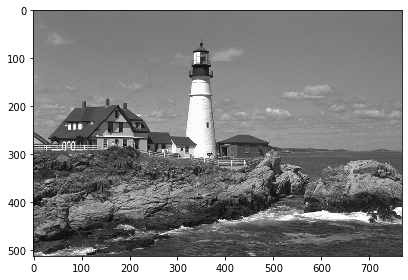

In [26]:
image = io.imread("lighthouse2.bmp")
image = rgb2gray(image)
plt.show()
image = rescale_intensity(image,out_range=(0,255)).astype(np.ubyte)
io.imshow(image ,cmap='gray')
image = image.clip(0,255)


# 2a


In [27]:
def GaussFilter( w ,sigma,mew ):
 x, y = np.meshgrid(np.linspace(-1,1,w), np.linspace(-1,1,w))
 dst = np.sqrt(y*y+x*x)
 sigma = 1
 mew=mew
 gauss = np.exp(-( (dst-mew)*(dst-mew) / ( 2.0 * (sigma*sigma) ) ) )
 res= gauss/(np.sum(gauss))
 return res


def GLPF_MSE(noise_img , filter_length ,std_deviation,sig ):
 error =[]
 k=0
 fl = 3
 sig = sig
 filtered_img =[]
 for i in filter_length:
    for j in std_deviation:
            gauss = GaussFilter(i,j,0)
            conv = signal.convolve2d(noise_img, gauss ,mode='same',boundary='fill',fillvalue=0)
            filtered_img.append(conv)
            mse = mean_squared_error(conv , image)
            error.append(mse)
            print ("Mean Squared Error with filter length being " ,i , " & sigma being" ,j,"is", mse)
            if(k>0):
              if(mse < error[k-1] ):
                fl = i
                sig = j
            k=k+1
 return     fl , sig

In [29]:
noise = np.reshape(np.random.normal(0,10,512*768),(512,768))
noise_img = image+noise
filter_length = [3,7,11]
std_deviation = [0.1,1,2,4,8]
sig=0.1
optimumFilterLength , optimumSigma = GLPF_MSE(noise_img , filter_length ,std_deviation,sig )
print("Optimal Filter Length is " ,optimumFilterLength, "Optimal Sigma is ",optimumSigma)

Mean Squared Error with filter length being  3  & sigma being 0.1 is 97.67892013772187
Mean Squared Error with filter length being  3  & sigma being 1 is 97.67892013772187
Mean Squared Error with filter length being  3  & sigma being 2 is 97.67892013772187
Mean Squared Error with filter length being  3  & sigma being 4 is 97.67892013772187
Mean Squared Error with filter length being  3  & sigma being 8 is 97.67892013772187
Mean Squared Error with filter length being  7  & sigma being 0.1 is 279.5638123526678
Mean Squared Error with filter length being  7  & sigma being 1 is 279.5638123526678
Mean Squared Error with filter length being  7  & sigma being 2 is 279.5638123526678
Mean Squared Error with filter length being  7  & sigma being 4 is 279.5638123526678
Mean Squared Error with filter length being  7  & sigma being 8 is 279.5638123526678
Mean Squared Error with filter length being  11  & sigma being 0.1 is 385.6697476450613
Mean Squared Error with filter length being  11  & sigma b

# 2b

In [30]:

gauss = GaussFilter(3,1,0)
muy = signal.convolve2d(noise_img, gauss ,mode='same',boundary='fill',fillvalue=0)

y1 = noise_img -muy
sigma_y1_sqr = y1.var()

gauss = GaussFilter(3,1,0)
sigmaZ1Squared = np.sum(gauss**2) - gauss[1,1]**2 + (1-gauss[1,1])**2
sigmaZ1Squared = sigmaZ1Squared*100

sigmaX1Squared = sigma_y1_sqr - sigmaZ1Squared
x_hat = muy - (sigmaX1Squared/(sigmaX1Squared+sigmaZ1Squared))*y1



print ("sigmaX1Squared is " , sigmaX1Squared)
print("sigmaZ1Squared is ",   sigmaZ1Squared)




sigmaX1Squared is  84.66938871031277
sigmaZ1Squared is  71.72445320530537


# 2c

In [17]:
def func1(i1,M,std):
    kernel=[np.exp(-(z**2)/(2*std**2))/np.sqrt(2*np.pi*std**2) for z in range(-M//2,M//2+1)]
    temp=kernel/np.sum(kernel)
    kernel=np.outer(temp,temp)
    ir=conv(i1,kernel,mode='same')
    return ir,kernel

In [18]:
def func2(imnh):
    varimh,std,M=np.var(imnh),1,3
    temp1,varz=3,100
    imnhhat=np.copy(imnh);count=imnhhat
    ker=[np.exp(-(z**2)/(2*std**2))/np.sqrt(2*np.pi*std**2) for z in range(-int(M/2),int(M/2)+1)]
    ker=ker/np.sum(ker);ker=np.outer(ker,ker)
    varzh=(np.sum(ker**2)-(ker[temp1//2,temp1//2])**2+(1-ker[temp1//2,temp1//2])**2)*varz
    for i in range(0,imnh.shape[0]-3,6):
        for j in range(0,imnh.shape[1]-7,6):
            imp1=imnh[i:i+11,j:j+11]
            varh=np.var(imp1)
            imnhhat[i:i+11,j:j+11]=((varh-varzh)/varh)*imp1
            count[i:i+11,j:j+11]+=1
    count[count==0]=1
    res=(imnhhat/count).astype("uint8")
    return res

[[109  78  93 ...  72  54  65]
 [ 99  56  37 ...  37  21  42]
 [ 87  22 248 ...   4 242  32]
 ...
 [ 58 225 233 ... 242 255 253]
 [ 60  19   0 ... 244 246 245]
 [141  59   7 ...   6   6  19]]
Best Gaussian Low Pass Filter Kernel Length = 3,with Standard Deviation = 1
[[ 13  28  38 ...  37  35  30]
 [ 29  67  90 ...  87  83  73]
 [ 40  92 123 ... 117 115 104]
 ...
 [ 50 118 159 ...  69  69  68]
 [ 42  96 129 ...  65  65  62]
 [ 37  85 116 ...  54  53  52]]
Mean Square Error of image is = 46.58027903238932


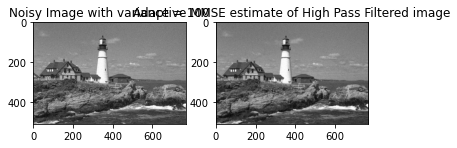

In [21]:
    i1 = cv.imread("lighthouse2.bmp", 0);ino=np.random.normal(0,10,i1.shape);varz=100
    ino =(ino+i1)
    ino[ino<0]=0;ino[ino>255]=255
    kerlen,std=[3,7,11],[0.1,1,2,4,8]
    minker,minstd=kerlen[0],std[1]
    imnl,ker=func1(ino,minker,minstd)
    imnh=ino-imnl
    imnh=np.array(imnh,np.uint8)
    print(imnh)
    ires=func2(imnh)+imnl
    print(f"Best Gaussian Low Pass Filter Kernel Length = {minker},with Standard Deviation = {minstd}")
    ires[ires>255]=255
    ires[ires<0]=0
    ires=np.array(ires,dtype=np.uint8)
    print(ires)
    print(f"Mean Square Error of image is = {np.mean((i1-ires)**2)}")
    plt.subplot(121)
    plt.title(f"Noisy Image with variance = 100")
    plt.imshow(ino,'gray')
    plt.subplot(122)
    plt.title(f"Adaptive MMSE estimate of High Pass Filtered image")
    plt.imshow(ires,'gray')
    plt.show()